In [2]:
import numpy as np

Author: Pierre Ablin

# Integrating mvlearn with scikit-learn

`mvlearn` mimics most of `scikit-learn` API, and integrates seamlessly with it. In scikit-learn, a dataset is represented as a 2d array `X` of shape `(n_samples, n_features)`. In `mvlearn`, datasets `Xs` are lists of views, which are themselves 2d arrays of shape `(n_samples, n_features_i)`. The number of features does not have to be constant:

In [3]:
n_samples = 100
n_features1 = 20
n_features2 = 30

X1 = np.random.randn(n_samples, n_features1)
X2 = np.random.randn(n_samples, n_features2)
Xs = [X1, X2]

Here, `Xs` is a multiview dataset, containing two views. `mvlearn` works with these objects.

# ViewTransformer

`mvlearn.preprocessing.ViewTransformer` is a handy tool to apply the same `sklearn` transformer to each view of the multiview dataset. For instance, it is simple to apply PCA to each view. In the following, we reduce the dimension of each view to 3:

In [4]:
from mvlearn.preprocessing import ViewTransformer
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
mvpca = ViewTransformer(pca)
Xs_transformed = mvpca.fit_transform(Xs)
print(len(Xs_transformed))
print([X.shape for X in Xs_transformed])

2
[(100, 3), (100, 3)]


The PCA is applied to each view with the `mvpca` transformer, and the output of PCA, `Xs_transformed`, is a multiview dataset, where each view now has `3`features.

Importantly, it is possible to apply a different transform to each view, by passing a list to `ViewTransformer`. For instance, if we want to keep 5 components in the second dataset, we can do:

In [5]:
pca2 = PCA(n_components=5)
mvpca = ViewTransformer([pca, pca2])
Xs_transformed = mvpca.fit_transform(Xs)
print(len(Xs_transformed))
print([X.shape for X in Xs_transformed])

2
[(100, 3), (100, 5)]


# Mergers

At the end of a multiview machine learning pipeline, it is sometimes needed to transform the multiview dataset in a single view dataset. All `sklearn` methods can then be used on this single view dataset. Mergers make this task simple. 

A simple way to transform a multiview dataset in a single view dataset is simply by stacking each features. The class `mvlearn.compose.ConcatMerger` implements this:

In [6]:
from mvlearn.compose import ConcatMerger

merge = ConcatMerger()

X_transformed = merge.fit_transform(Xs)
print(X_transformed.shape)

(100, 50)


This allows for simple integration in scikit-learn pipelines.

# Pipeline example: group-ICA

As a simple illustration, we now show how easy it is to code group independent component analysis (groupICA) from scratch using `mvlearn`.

We use the group ICA of *Calhoun et al. "A method for making group inferences from functional MRI data using independent component analysis.", Human brain mapping 14.3 (2001): 140-151.* as reference.

GroupICA takes a multiview dataset, and tries to extract from it some shared independent sources. In its usual formulation, it consists of three simple steps:

- Apply an individual PCA to each view
- Concatenate the features of each view
- Apply usual ICA on the concatenated features

This is easily implemented using `mvlearn` and scikit-learn pipelines:

In [7]:
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline

n_components = 2
individual_pca = ViewTransformer(PCA(n_components=n_components))
merge = ConcatMerger()
ica = FastICA(n_components=n_components)

groupica = Pipeline([('individual pca', individual_pca),
                     ('concatenate', merge),
                     ('ica', ica)])

X_transformed = groupica.fit_transform(Xs)
print(X_transformed.shape)

(100, 2)


Here, `Xs` contains Gaussian noise, so nothing of value is extracted. However, if each view consists of a linear transform of some independent sources, it works as intended:

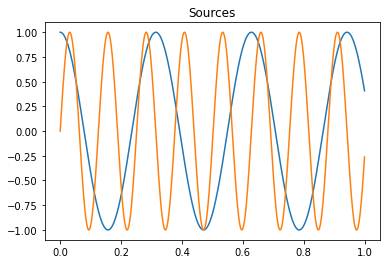

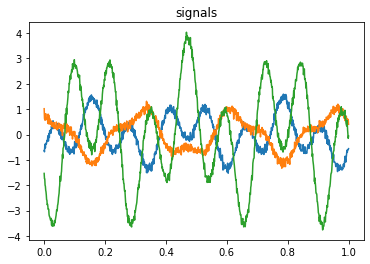

In [8]:
import matplotlib.pyplot as plt
time = np.linspace(0, 1, 1000)
source1 = np.cos(20 * time)
source2 = np.sin(50 * time)
S = np.c_[source1, source2]
A1 = np.random.randn(3, 2)
A2 = np.random.randn(4, 2)
X1 = np.dot(S, A1.T) + .1 * np.random.randn(1000, 3)
X2 = np.dot(S, A2.T) + .1 * np.random.randn(1000, 4)
Xs = [X1, X2]
plt.figure()
plt.plot(time, source1, time, source2)
plt.title('Sources')

plt.figure()
for x in X1.T:
    plt.plot(time, x)
plt.title('signals');

In [9]:
X_transformed = groupica.fit_transform(Xs)

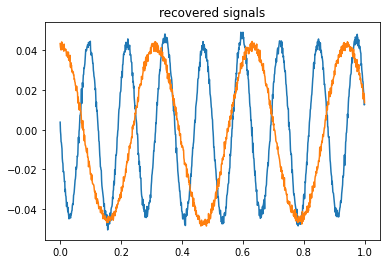

In [10]:
for x in X_transformed.T:
    plt.plot(time, x)
plt.title('recovered signals');